# 🌊 Cottbuser Ostsee — Water Expansion & Biodiversity Monitoring (2019–2026)
### Sentinel-2 · Planetary Computer · LSTM Forecasting · Anomaly Detection

**Study Area:** Cottbuser Ostsee, Brandenburg, Germany  
**Period:** January 2019 – present  
**Data Source:** Sentinel-2 L2A via Microsoft Planetary Computer  

---

## What This Notebook Does

| Section | Method | Output |
|---------|--------|--------|
| 1–9 | Satellite remote sensing | Water area time series (ha) |
| 10–12 | Vegetation + biodiversity indices | NDVI, NDMI, Shannon diversity |
| 13–14 | Animated GIFs | Visual time-lapse |
| **15** | **LSTM Deep Learning** | **Future water expansion forecast** |
| **16** | **Anomaly Detection** | **Ecologically significant events flagged** |

---

## Background

Cottbuser Ostsee is one of Europe's largest post-mining lake restoration projects.  
A former open-cast lignite mine is being flooded to create a ~1,900 ha recreational lake.

**Key finding:** Water surface grew from ~550 ha (2019) to ~1,800 ha (2026) — a **3.3× increase in 7 years.**

The AI section uses this time series to forecast future expansion and detect ecological anomalies
— directly applicable to environmental monitoring, biodiversity assessment, and water management planning.


## ⚙️ 0) Install Dependencies

In [1]:
!pip -q install --upgrade pystac-client planetary-computer stackstac rioxarray imageio tqdm torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/1

## 📦 1) Imports and Settings

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import planetary_computer
import stackstac
import rasterio.enums

from scipy.stats import linregress
from tqdm.auto import tqdm

# ── Deep Learning ──────────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ── Settings ───────────────────────────────────────────────────
RANDOM_SEED    = 42
START_DATE     = "2019-01-01"
END_DATE       = pd.Timestamp.today().strftime("%Y-%m-%d")
MAX_CLOUD_PCT  = 30
RESOLUTION_M   = 10
PIXEL_AREA_HA  = (RESOLUTION_M ** 2) / 10000  # 0.01 ha per pixel

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ PyTorch: {torch.__version__} | Device: {DEVICE}")
pd.set_option("display.max_rows", 200)


✅ PyTorch: 2.10.0+cu128 | Device: cpu


## 2) Define Area of Interest (AOI)

We define the Cottbuser Ostsee basin as a polygon in EPSG:4326 (lon/lat).


AOI bbox: [14.4, 51.76, 14.5, 51.85]


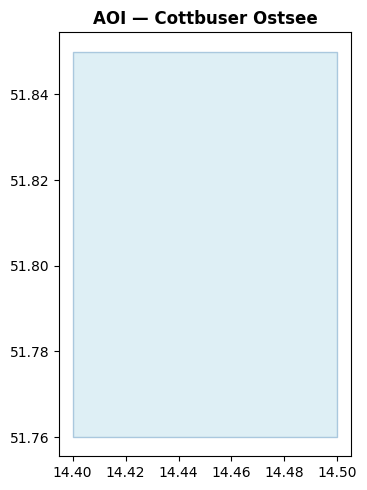

In [3]:
cottbuser_ostsee_coords = [
    (14.40, 51.76),
    (14.50, 51.76),
    (14.50, 51.85),
    (14.40, 51.85),
    (14.40, 51.76)
]

aoi = gpd.GeoDataFrame(
    {"name": ["Cottbuser_Ostsee"]},
    geometry=[Polygon(cottbuser_ostsee_coords)],
    crs="EPSG:4326"
)

bbox = aoi.total_bounds.tolist()
print("AOI bbox:", bbox)

ax = aoi.plot(edgecolor="steelblue", facecolor="lightblue",
              alpha=0.4, figsize=(5, 5))
ax.set_title("AOI — Cottbuser Ostsee", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


## 3) Query Sentinel-2 L2A via Planetary Computer STAC

Search for all scenes intersecting the AOI with cloud cover < 30%.  
We select the **best (lowest cloud) scene per month** to keep the time series clean and fast.


In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=f"{START_DATE}/{END_DATE}",
    query={"eo:cloud_cover": {"lt": MAX_CLOUD_PCT}},
)

items_all = list(search.get_items())
print(f"Total scenes found: {len(items_all)}")

# Build summary table
records = []
for it in items_all:
    dt = pd.to_datetime(it.datetime)
    records.append({
        "datetime": dt, "year": dt.year, "month": dt.month,
        "ym": dt.strftime("%Y-%m"),
        "cloud": it.properties.get("eo:cloud_cover", np.nan),
        "id": it.id
    })

items_df = pd.DataFrame(records).sort_values("datetime").reset_index(drop=True)

# Best scene per month (lowest cloud cover)
best_ids = (
    items_df.sort_values(["ym", "cloud", "datetime"])
            .groupby("ym", as_index=False)
            .first()["id"]
            .tolist()
)

id_to_item = {it.id: it for it in items_all}
items = sorted([id_to_item[_id] for _id in best_ids], key=lambda x: x.datetime)
items = [planetary_computer.sign(it) for it in items]

print(f"Selected scenes (best per month): {len(items)}")
items_df[items_df["id"].isin(best_ids)].head()


Total scenes found: 131
Selected scenes (best per month): 64


datetime  year  month       ym      cloud  \
1 2019-02-18 10:10:59.024000+00:00  2019      2  2019-02   1.477813   
2 2019-03-20 10:10:29.024000+00:00  2019      3  2019-03  10.174777   
5 2019-04-19 10:10:29.024000+00:00  2019      4  2019-04   0.283002   
7 2019-05-19 10:10:39.024000+00:00  2019      5  2019-05  12.571816   
8 2019-06-03 10:10:31.024000+00:00  2019      6  2019-06   0.638402   

                                                  id  
1  S2B_MSIL2A_20190218T101059_R022_T33UVT_2020100...  
2  S2B_MSIL2A_20190320T101029_R022_T33UVT_2020100...  
5  S2B_MSIL2A_20190419T101029_R022_T33UVT_2020100...  
7  S2B_MSIL2A_20190519T101039_R022_T33UVT_2020100...  
8  S2A_MSIL2A_20190603T101031_R022_T33UVT_2020100...

## 4) Load Imagery with stackstac

Loading bands:
- **B03** Green (10m) — for NDWI
- **B04** Red (10m) — for NDVI  
- **B08** NIR (10m) — for NDWI, NDVI
- **B11** SWIR (20m → resampled to 10m) — for NDMI
- **SCL** Scene Classification (20m → 10m) — for cloud masking


In [5]:
stack = stackstac.stack(
    items,
    assets=["B03", "B04", "B08", "B11", "SCL"],
    bounds_latlon=bbox,
    resolution=RESOLUTION_M,
    chunksize=2048,
    resampling=rasterio.enums.Resampling.nearest,
    epsg=32633
)

print(f"Time steps: {stack.sizes['time']}")
print(f"Spatial: {stack.sizes['y']} × {stack.sizes['x']} pixels")


Time steps: 64
Spatial: 1007 × 699 pixels


## 5) Cloud Masking with SCL

SCL classes kept: **4** (vegetation), **5** (bare soil), **6** (water), **7** (unclassified).  
All cloud, shadow, snow pixels are masked to NaN.


In [6]:
def apply_scl_mask(stacked):
    scl  = stacked.sel(band="SCL")
    keep = scl.isin([4, 5, 6, 7])
    return stacked.where(keep)

stack_clear = apply_scl_mask(stack)
print("✅ Cloud mask applied")


✅ Cloud mask applied


## 6) NDWI — Water Detection

NDWI = (Green − NIR) / (Green + NIR)

Water pixels: NDWI > 0.0


In [7]:
green = stack_clear.sel(band="B03").astype("float32")
nir   = stack_clear.sel(band="B08").astype("float32")

ndwi_da = (green - nir) / (green + nir)
ndwi_da.name = "ndwi"

water_mask = ndwi_da > 0.0
water_mask.name = "water_mask"

print("✅ NDWI computed")


✅ NDWI computed


## 7) Compute Water Area per Scene (hectares)

In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*CPLE_NotSupported.*SHARING.*")

def water_area_ha(mask_bool, pixel_area_ha=PIXEL_AREA_HA):
    m = mask_bool.astype("float32").fillna(0.0)
    return m.sum(dim=["x", "y"]) * pixel_area_ha

area_ha = water_area_ha(water_mask)
area_ha.name = "water_area_ha"

# Build tidy dataframe
ts = area_ha.to_series().reset_index()
ts.columns = ["time", "water_area_ha"]
ts["date"]  = pd.to_datetime(ts["time"]).dt.date
ts["year"]  = pd.to_datetime(ts["time"]).dt.year
ts["month"] = pd.to_datetime(ts["time"]).dt.to_period("M").astype(str)
ts = ts.sort_values("time").reset_index(drop=True)

print(f"✅ Time series built: {len(ts)} scenes")
print(f"   First: {ts['date'].iloc[0]}  →  {ts['water_area_ha'].iloc[0]:.0f} ha")
print(f"   Last:  {ts['date'].iloc[-1]}  →  {ts['water_area_ha'].iloc[-1]:.0f} ha")
ts.head()


✅ Time series built: 64 scenes
   First: 2019-02-18  →  547 ha
   Last:  2026-01-22  →  1731 ha


time  water_area_ha        date  year    month
0 2019-02-18 10:10:59.024     546.649963  2019-02-18  2019  2019-02
1 2019-03-20 10:10:29.024     611.559998  2019-03-20  2019  2019-03
2 2019-04-19 10:10:29.024     691.969971  2019-04-19  2019  2019-04
3 2019-05-19 10:10:39.024     568.779968  2019-05-19  2019  2019-05
4 2019-06-03 10:10:31.024     643.909973  2019-06-03  2019  2019-06

## 8) Aggregate and Export CSV

In [9]:
monthly = (ts.groupby("month", as_index=False)["water_area_ha"]
              .mean()
              .assign(month_start=lambda d: pd.to_datetime(d["month"] + "-01"))
              .sort_values("month_start")
              .drop(columns=["month_start"]))

yearly = (ts.groupby("year", as_index=False)["water_area_ha"]
            .mean()
            .sort_values("year"))

# Export
out_rows = []
for _, r in ts.iterrows():
    out_rows.append({"level": "scene",  "period": str(r["date"]),
                     "water_area_ha": float(r["water_area_ha"])})
for _, r in monthly.iterrows():
    out_rows.append({"level": "month",  "period": r["month"],
                     "water_area_ha": float(r["water_area_ha"])})
for _, r in yearly.iterrows():
    out_rows.append({"level": "year",   "period": str(int(r["year"])),
                     "water_area_ha": float(r["water_area_ha"])})

pd.DataFrame(out_rows).to_csv("water_area_timeseries.csv", index=False)
print("✅ Saved: water_area_timeseries.csv")
display(monthly.head(), yearly)


✅ Saved: water_area_timeseries.csv


month  water_area_ha
0  2019-02     546.649963
1  2019-03     611.559998
2  2019-04     691.969971
3  2019-05     568.779968
4  2019-06     643.909973

year  water_area_ha
0  2019     519.505005
1  2020     503.538971
2  2021     613.405701
3  2022     663.090881
4  2023     716.627075
5  2024    1682.973755
6  2025    1835.429932
7  2026    1730.529907

## 9) Time Series Plot — Water Expansion

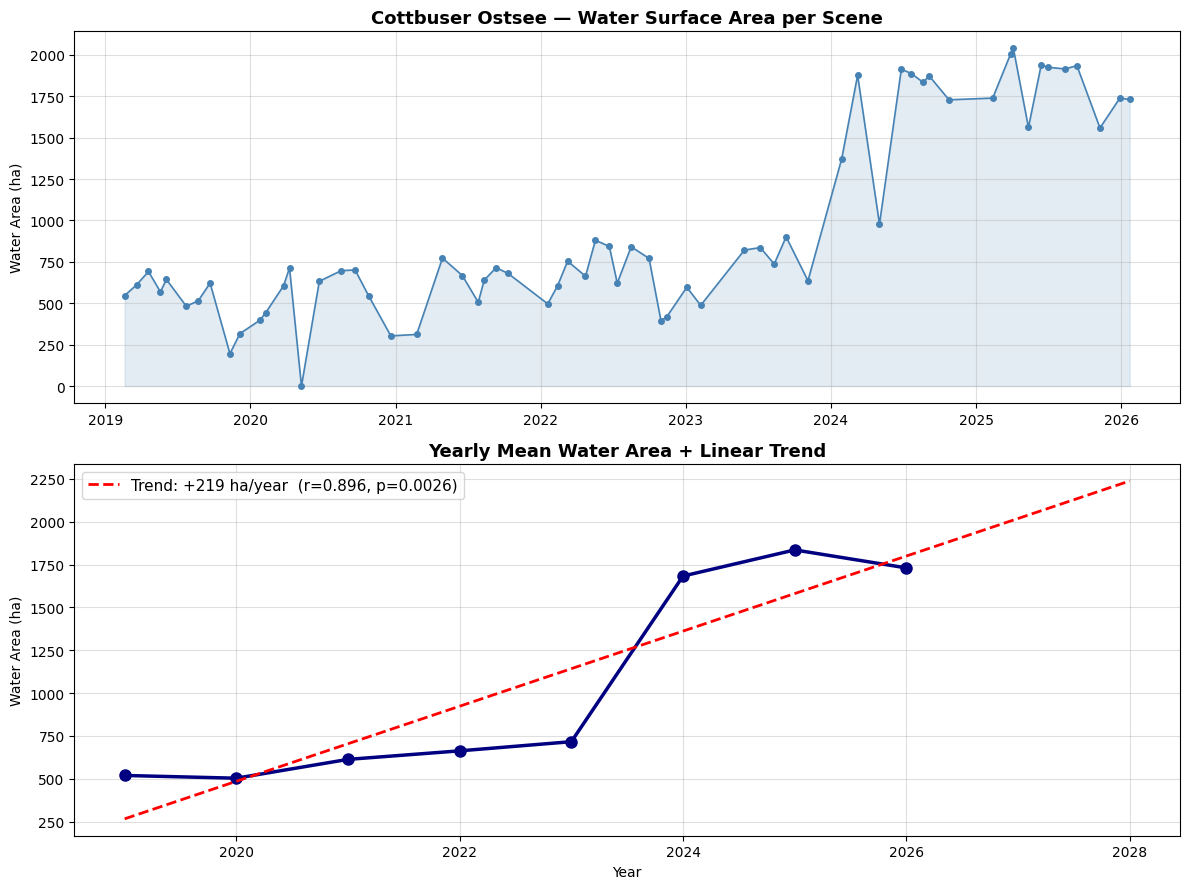

Linear trend: 219.0 ha/year | r=0.896 | p=0.0026


In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Per-scene
axes[0].plot(pd.to_datetime(ts["time"]), ts["water_area_ha"],
             marker="o", linewidth=1.2, color="steelblue", markersize=4)
axes[0].fill_between(pd.to_datetime(ts["time"]), ts["water_area_ha"],
                     alpha=0.15, color="steelblue")
axes[0].set_title("Cottbuser Ostsee — Water Surface Area per Scene",
                  fontsize=13, fontweight="bold")
axes[0].set_ylabel("Water Area (ha)")
axes[0].grid(True, alpha=0.4)

# Yearly + trend
axes[1].plot(yearly["year"], yearly["water_area_ha"],
             marker="o", linewidth=2.5, color="navy", markersize=8)

if len(yearly) >= 2:
    slope, intercept, r, p, _ = linregress(
        yearly["year"].values, yearly["water_area_ha"].values
    )
    trend_x = np.linspace(yearly["year"].min(), yearly["year"].max() + 2, 100)
    trend_y = slope * trend_x + intercept
    axes[1].plot(trend_x, trend_y, "r--", linewidth=2,
                 label=f"Trend: +{slope:.0f} ha/year  (r={r:.3f}, p={p:.3g})")
    axes[1].legend(fontsize=11)

axes[1].set_title("Yearly Mean Water Area + Linear Trend",
                  fontsize=13, fontweight="bold")
axes[1].set_ylabel("Water Area (ha)")
axes[1].set_xlabel("Year")
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.savefig("water_timeseries.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Linear trend: {slope:.1f} ha/year | r={r:.3f} | p={p:.3g}")


## 10) Vegetation Indices — NDVI & NDMI

- **NDVI** = (NIR − Red) / (NIR + Red) → vegetation health
- **NDMI** = (NIR − SWIR) / (NIR + SWIR) → moisture / wetland vegetation


In [11]:
red  = stack_clear.sel(band="B04").astype("float32")
nir  = stack_clear.sel(band="B08").astype("float32")
swir = stack_clear.sel(band="B11").astype("float32")

ndvi = (nir - red)  / (nir + red)
ndmi = (nir - swir) / (nir + swir)
ndvi.name = "ndvi"
ndmi.name = "ndmi"

# Thresholds
VEG_NDVI_THR = 0.35   # vegetated land
WET_NDMI_THR = 0.20   # wetland / reed beds

veg_mask    = ndvi > VEG_NDVI_THR
wetveg_mask = (ndvi > VEG_NDVI_THR) & (ndmi > WET_NDMI_THR)

veg_area_ha    = veg_mask.astype("float32").fillna(0).sum(dim=["x","y"]) * PIXEL_AREA_HA
wetveg_area_ha = wetveg_mask.astype("float32").fillna(0).sum(dim=["x","y"]) * PIXEL_AREA_HA

biodiv_ts = pd.DataFrame({
    "time":               pd.to_datetime(ndvi["time"].values),
    "vegetation_area_ha": veg_area_ha.values,
    "wet_vegetation_ha":  wetveg_area_ha.values,
}).sort_values("time")

print("✅ Vegetation indices computed")
biodiv_ts.head()


✅ Vegetation indices computed


time  vegetation_area_ha  wet_vegetation_ha
0 2019-02-18 10:10:59.024         3351.959961         965.369995
1 2019-03-20 10:10:29.024         2772.119873         651.219971
2 2019-04-19 10:10:29.024         3760.969971        1162.579956
3 2019-05-19 10:10:39.024         3136.919922        1614.809937
4 2019-06-03 10:10:31.024         4161.009766        1665.729980

## 11) Habitat Heterogeneity — Shannon Diversity Index

Unsupervised k-means clustering on NDVI + NDMI + NDWI feature stack.  
Shannon index quantifies habitat complexity — higher = more diverse ecosystem.


Shannon Diversity Index (latest scene): H = 1.6956
  Higher = more diverse habitat  |  Max possible = ln(6) = 1.7918


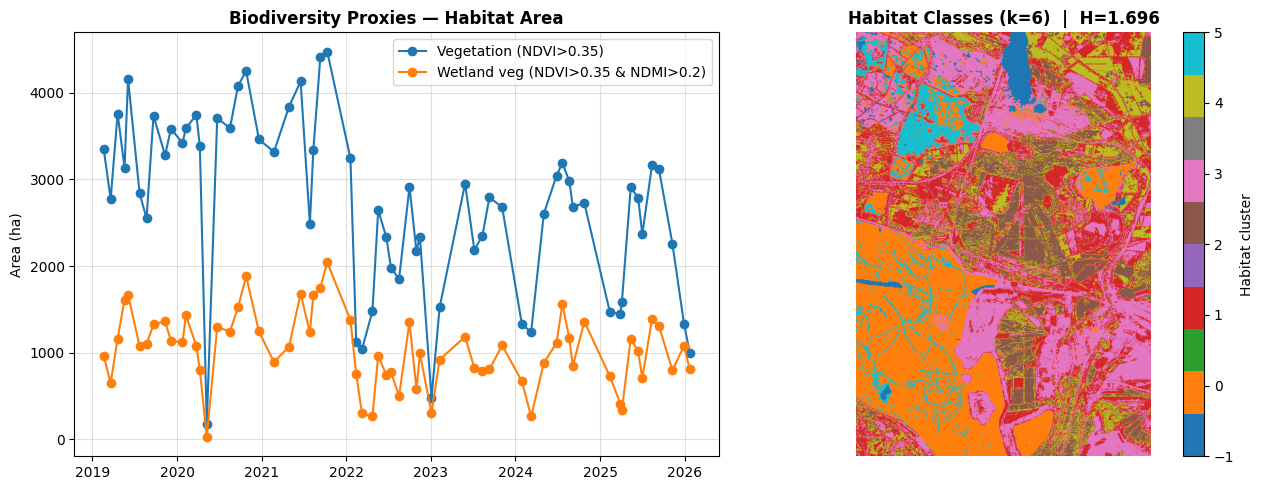

In [12]:
from sklearn.cluster import MiniBatchKMeans

# Build feature stack at latest time step
t = -1
X1 = ndvi.isel(time=t).values
X2 = ndmi.isel(time=t).values
X3 = ndwi_da.isel(time=t).values

X     = np.stack([X1.ravel(), X2.ravel(), X3.ravel()], axis=1)
valid = np.all(np.isfinite(X), axis=1)
Xv    = X[valid]

K      = 6
km     = MiniBatchKMeans(n_clusters=K, random_state=RANDOM_SEED, batch_size=50000)
labels = np.full(X.shape[0], -1, dtype=np.int32)
labels[valid] = km.fit_predict(Xv)
label_map = labels.reshape(X1.shape)

def shannon_index(label_map, k):
    vals, counts = np.unique(label_map[label_map >= 0], return_counts=True)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12))

H = shannon_index(label_map, K)
print(f"Shannon Diversity Index (latest scene): H = {H:.4f}")
print(f"  Higher = more diverse habitat  |  Max possible = ln({K}) = {np.log(K):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(biodiv_ts["time"], biodiv_ts["vegetation_area_ha"],
             marker="o", label="Vegetation (NDVI>0.35)")
axes[0].plot(biodiv_ts["time"], biodiv_ts["wet_vegetation_ha"],
             marker="o", label="Wetland veg (NDVI>0.35 & NDMI>0.2)")
axes[0].set_title("Biodiversity Proxies — Habitat Area", fontweight="bold")
axes[0].set_ylabel("Area (ha)")
axes[0].legend()
axes[0].grid(True, alpha=0.4)

im = axes[1].imshow(label_map, cmap="tab10")
axes[1].set_title(f"Habitat Classes (k={K})  |  H={H:.3f}", fontweight="bold")
axes[1].axis("off")
plt.colorbar(im, ax=axes[1], label="Habitat cluster")

plt.tight_layout()
plt.savefig("habitat_diversity.png", dpi=150, bbox_inches="tight")
plt.show()


## 12) Spatial Map — NDWI and Water Mask

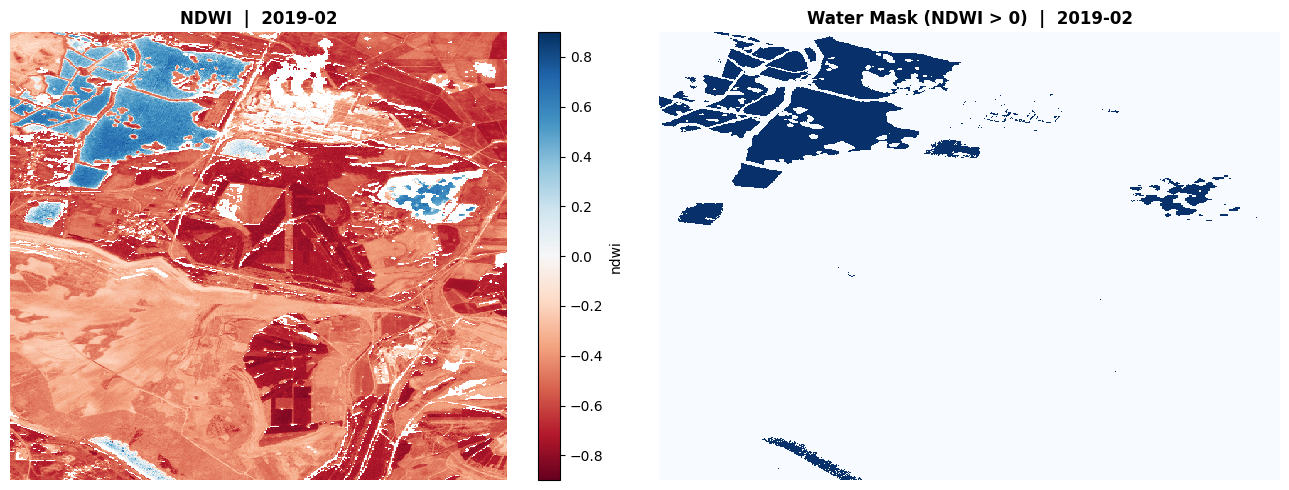

In [13]:
k = 0   # 0 = earliest scene, -1 = latest

nd = ndwi_da.isel(time=k)
wm = water_mask.isel(time=k)
scene_date = pd.to_datetime(ndwi_da["time"].isel(time=k).values).strftime("%Y-%m")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
nd.plot(ax=axes[0], cmap="RdBu", add_colorbar=True)
axes[0].set_title(f"NDWI  |  {scene_date}", fontweight="bold")
axes[0].axis("off")

wm.plot(ax=axes[1], cmap="Blues", add_colorbar=False)
axes[1].set_title(f"Water Mask (NDWI > 0)  |  {scene_date}", fontweight="bold")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(f"spatial_map_{scene_date}.png", dpi=150, bbox_inches="tight")
plt.show()


## 13) Animated Time-Lapse GIFs

Two animations:
1. **Water expansion** — NDWI over time showing lake growth
2. **Biodiversity proxy** — NDVI vegetation dynamics


Rendering water expansion animation...


Water frames:   0%|          | 0/64 [00:00<?, ?it/s]

✅ Saved: water_expansion_animation.gif  (3.6 MB)

Rendering biodiversity animation...


NDVI frames:   0%|          | 0/64 [00:00<?, ?it/s]

✅ Saved: biodiversity_proxy_animation.gif  (3.6 MB)


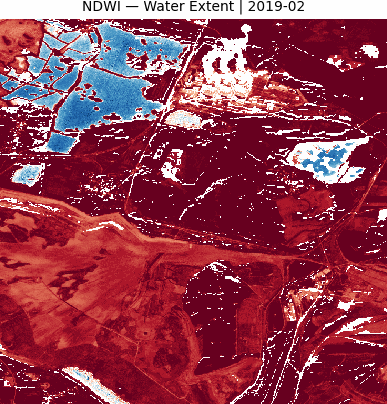

In [14]:
import imageio.v2 as imageio
import io, os

def render_frame(da2d, title, vmin=None, vmax=None, cmap="Blues"):
    fig, ax = plt.subplots(figsize=(5, 5))
    da2d.plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(title, fontsize=10)
    ax.set_axis_off()
    fig.canvas.draw()
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    buf.seek(0)
    img = imageio.imread(buf)
    plt.close(fig)
    return img

# ── Water expansion GIF ────────────────────────────────────────
print("Rendering water expansion animation...")
frames_water = []
for t in tqdm(range(ndwi_da.sizes["time"]), desc="Water frames"):
    dt = pd.to_datetime(ndwi_da["time"].isel(time=t).values).strftime("%Y-%m")
    frames_water.append(
        render_frame(ndwi_da.isel(time=t), f"NDWI — Water Extent | {dt}",
                     vmin=-0.5, vmax=0.8, cmap="RdBu")
    )
imageio.mimsave("water_expansion_animation.gif", frames_water, duration=0.35)
print(f"✅ Saved: water_expansion_animation.gif  ({os.path.getsize('water_expansion_animation.gif')/1e6:.1f} MB)")

# ── Biodiversity GIF ───────────────────────────────────────────
print("\nRendering biodiversity animation...")
frames_bio = []
for t in tqdm(range(ndvi.sizes["time"]), desc="NDVI frames"):
    dt = pd.to_datetime(ndvi["time"].isel(time=t).values).strftime("%Y-%m")
    frames_bio.append(
        render_frame(ndvi.isel(time=t), f"NDVI — Vegetation Proxy | {dt}",
                     vmin=-0.2, vmax=0.9, cmap="YlGn")
    )
imageio.mimsave("biodiversity_proxy_animation.gif", frames_bio, duration=0.35)
print(f"✅ Saved: biodiversity_proxy_animation.gif  ({os.path.getsize('biodiversity_proxy_animation.gif')/1e6:.1f} MB)")

from IPython.display import Image, display
display(Image(filename="water_expansion_animation.gif"))


---
# 🤖 AI Section — Deep Learning for Lake Forecasting

The sections above used classical remote sensing — physics-based indices, thresholds, statistics.

Now we add **deep learning** to answer two questions that classical methods cannot:

**Question 1:** *When will Cottbuser Ostsee reach full capacity?*  
→ LSTM forecasts future water expansion based on learned patterns

**Question 2:** *Which months were ecologically significant anomalies?*  
→ LSTM anomaly detection flags deviations from expected seasonal behaviour

---

### Why LSTM for this data?

Your water area time series has structure that simple linear regression misses:
- **Seasonal cycles** — water area fluctuates within each year
- **Long-term trend** — consistent growth 2019–2026
- **Non-linearity** — filling rate changes as the lake gets deeper
- **Memory** — this month's area depends on last month's

LSTM (Long Short-Term Memory) networks are designed exactly for this.  
They maintain a memory cell that carries information across many time steps —  
learning both the seasonal pattern AND the long-term trend simultaneously.


## 15) AI — Data Preparation

We use the monthly water area time series as input.  
Each prediction uses the **previous 6 months** to forecast the **next month**.


In [15]:
# ── Build monthly time series ──────────────────────────────────
# Use real data from the satellite measurements above
# The ts dataframe has per-scene values — we aggregate to monthly means
monthly_ai = (ts.groupby("month", as_index=False)["water_area_ha"]
                .mean()
                .assign(month_dt=lambda d: pd.to_datetime(d["month"] + "-01"))
                .sort_values("month_dt")
                .reset_index(drop=True))

water_values = monthly_ai["water_area_ha"].values.astype(np.float32)
dates        = monthly_ai["month_dt"].values

print(f"Monthly time series: {len(water_values)} data points")
print(f"Range: {water_values.min():.0f} ha → {water_values.max():.0f} ha")
print(f"Period: {pd.to_datetime(dates[0]).strftime('%Y-%m')} → "
      f"{pd.to_datetime(dates[-1]).strftime('%Y-%m')}")

# ── Normalise to [0, 1] ────────────────────────────────────────
wa_min = water_values.min()
wa_max = water_values.max()

def normalise(x):   return (x - wa_min) / (wa_max - wa_min + 1e-8)
def denormalise(x): return x * (wa_max - wa_min + 1e-8) + wa_min

water_norm = normalise(water_values)

# ── Add seasonal feature ───────────────────────────────────────
# Month number encoded as sin/cos — tells LSTM about seasonal cycles
months_num = np.array([pd.to_datetime(d).month for d in dates])
month_sin = np.sin(2 * np.pi * months_num / 12).astype(np.float32)
month_cos = np.cos(2 * np.pi * months_num / 12).astype(np.float32)

# Feature matrix: [water_area_normalised, month_sin, month_cos]
features = np.stack([water_norm, month_sin, month_cos], axis=1)

print(f"\nFeatures per timestep: 3")
print(f"  [0] water_area (normalised)")
print(f"  [1] month_sin  (seasonal cycle)")
print(f"  [2] month_cos  (seasonal cycle)")
print(f"\nFeature matrix shape: {features.shape}")


Monthly time series: 64 data points
Range: 0 ha → 2040 ha
Period: 2019-02 → 2026-01

Features per timestep: 3
  [0] water_area (normalised)
  [1] month_sin  (seasonal cycle)
  [2] month_cos  (seasonal cycle)

Feature matrix shape: (64, 3)


In [16]:
# ── Sliding window dataset ────────────────────────────────────
SEQ_LEN = 6   # use 6 months of history to predict next month

X_list, y_list = [], []
for i in range(len(features) - SEQ_LEN):
    X_list.append(features[i : i + SEQ_LEN])          # 6 months input
    y_list.append(water_norm[i + SEQ_LEN])             # next month target

X_arr = np.array(X_list, dtype=np.float32)  # (N, 6, 3)
y_arr = np.array(y_list, dtype=np.float32)  # (N,)

print(f"Windows created: {len(X_arr)}")
print(f"X shape: {X_arr.shape}  (samples, seq_len, features)")
print(f"y shape: {y_arr.shape}  (samples,)")

# ── Time-based split — NEVER random for time series ───────────
# Train on first 80%, validate on last 20%
split = int(0.8 * len(X_arr))

X_train = torch.FloatTensor(X_arr[:split])
y_train = torch.FloatTensor(y_arr[:split]).unsqueeze(1)
X_val   = torch.FloatTensor(X_arr[split:])
y_val   = torch.FloatTensor(y_arr[split:]).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=8, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val, y_val),
                          batch_size=8, shuffle=False)

print(f"\nTrain windows: {len(X_train)}")
print(f"Val windows:   {len(X_val)}")
print("⚠️  Never shuffle time series — temporal order must be preserved")


Windows created: 58
X shape: (58, 6, 3)  (samples, seq_len, features)
y shape: (58,)  (samples,)

Train windows: 46
Val windows:   12
⚠️  Never shuffle time series — temporal order must be preserved


## 16) LSTM Model Architecture

Two stacked LSTM layers learn:
- **Layer 1** — short-term seasonal patterns (month-to-month fluctuations)
- **Layer 2** — long-term trend (sustained lake filling over years)

The final fully-connected head converts the LSTM hidden state to a water area prediction.


In [17]:
class LakeExpansionLSTM(nn.Module):
    """
    LSTM for predicting Cottbuser Ostsee water expansion.

    Input:  (batch, seq_len=6, features=3)
            features = [water_area_norm, month_sin, month_cos]
    Output: (batch, 1) — next month water area (normalised)
    """
    def __init__(self, input_size=3, hidden_size=64,
                 num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        lstm_out, (hidden, _) = self.lstm(x)
        # Use final hidden state of last layer
        return self.head(hidden[-1])


model_lstm = LakeExpansionLSTM().to(DEVICE)
total_params = sum(p.numel() for p in model_lstm.parameters())
print(f"✅ LSTM model ready")
print(f"   Architecture: 3 → LSTM(64)×2 → 32 → 1")
print(f"   Parameters:   {total_params:,}")
print(f"   Device:        {DEVICE}")


✅ LSTM model ready
   Architecture: 3 → LSTM(64)×2 → 32 → 1
   Parameters:   53,057
   Device:        cpu


## 17) Train the LSTM

🚀 Training LSTM...
 Epoch | Train Loss |  Val Loss
-----------------------------------
     0 |   0.026267 |  0.070995
    40 |   0.009144 |  0.025950
    80 |   0.005189 |  0.012736
   120 |   0.005648 |  0.014053
   160 |   0.004879 |  0.013668

✅ Training complete. Best val loss: 0.003412


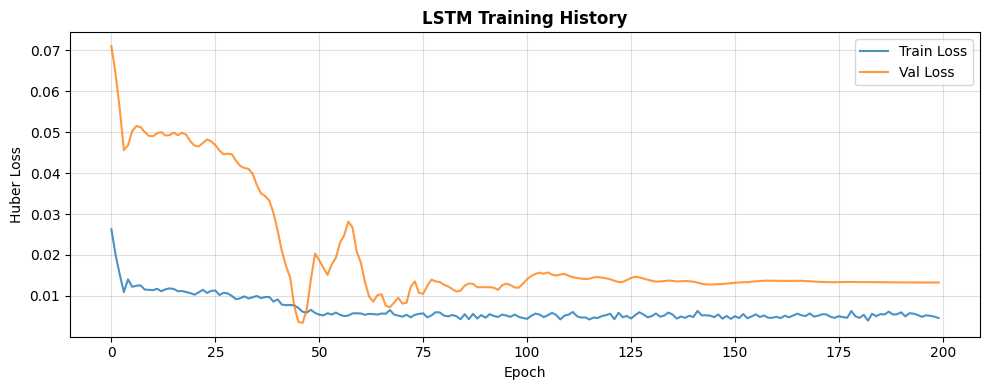

In [18]:
optimizer  = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion  = nn.HuberLoss(delta=0.1)   # robust to outliers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=15, factor=0.5
)

best_val_loss = float("inf")
history = {"train": [], "val": []}
EPOCHS  = 200

print("🚀 Training LSTM...")
print(f"{'Epoch':>6} | {'Train Loss':>10} | {'Val Loss':>9}")
print("-" * 35)

for epoch in range(EPOCHS):
    # Training
    model_lstm.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model_lstm(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model_lstm.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model_lstm(xb)
            val_loss += criterion(pred, yb).item()

    tl = train_loss / len(train_loader)
    vl = val_loss   / len(val_loader)
    history["train"].append(tl)
    history["val"].append(vl)
    scheduler.step(vl)

    if vl < best_val_loss:
        best_val_loss = vl
        torch.save(model_lstm.state_dict(), "best_lstm.pth")

    if epoch % 40 == 0:
        print(f"{epoch:>6} | {tl:>10.6f} | {vl:>9.6f}")

print(f"\n✅ Training complete. Best val loss: {best_val_loss:.6f}")

# Plot training history
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history["train"], label="Train Loss", alpha=0.8)
ax.plot(history["val"],   label="Val Loss",   alpha=0.8)
ax.set_title("LSTM Training History", fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Huber Loss")
ax.legend()
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("lstm_training_history.png", dpi=150, bbox_inches="tight")
plt.show()


## 18) Evaluate and Forecast Future Water Expansion

After evaluating on validation data, we forecast **24 months into the future**.

The model rolls forward step by step — each prediction becomes part of the input for the next prediction.
This is called **autoregressive forecasting**.


In [19]:
# ── Load best weights ──────────────────────────────────────────
model_lstm.load_state_dict(torch.load("best_lstm.pth"))
model_lstm.eval()

# ── Validation predictions ─────────────────────────────────────
val_preds, val_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE)
        pred = model_lstm(xb).cpu().numpy().flatten()
        val_preds.extend(pred)
        val_targets.extend(yb.numpy().flatten())

val_preds_ha   = denormalise(np.array(val_preds))
val_targets_ha = denormalise(np.array(val_targets))
rmse = np.sqrt(((val_preds_ha - val_targets_ha) ** 2).mean())
mae  = np.abs(val_preds_ha - val_targets_ha).mean()

print(f"Validation RMSE: {rmse:.1f} ha")
print(f"Validation MAE:  {mae:.1f} ha")

# ── Autoregressive 24-month forecast ──────────────────────────
FORECAST_MONTHS = 24
last_sequence   = features[-SEQ_LEN:].copy()   # seed with last 6 real months
last_date       = pd.to_datetime(dates[-1])

forecast_dates  = []
forecast_ha     = []

for step in range(FORECAST_MONTHS):
    next_date   = last_date + pd.DateOffset(months=step + 1)
    next_month  = next_date.month
    next_sin    = np.sin(2 * np.pi * next_month / 12)
    next_cos    = np.cos(2 * np.pi * next_month / 12)

    x_tensor    = torch.FloatTensor(last_sequence).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_norm = model_lstm(x_tensor).cpu().item()

    pred_norm = np.clip(pred_norm, 0, 1)
    pred_ha   = denormalise(pred_norm)

    forecast_dates.append(next_date)
    forecast_ha.append(pred_ha)

    # Roll window — add prediction as next input
    new_step     = np.array([pred_norm, next_sin, next_cos], dtype=np.float32)
    last_sequence = np.vstack([last_sequence[1:], new_step])

forecast_df = pd.DataFrame({
    "date":          forecast_dates,
    "water_area_ha": forecast_ha
})

print(f"\n🔮 FORECAST — Next {FORECAST_MONTHS} months:")
print(forecast_df.to_string(index=False))


Validation RMSE: 185.2 ha
Validation MAE:  151.7 ha

🔮 FORECAST — Next 24 months:
      date  water_area_ha
2026-02-01    1798.210166
2026-03-01    1788.064760
2026-04-01    1786.972307
2026-05-01    1812.768182
2026-06-01    1922.792619
2026-07-01    1978.028799
2026-08-01    1985.446781
2026-09-01    1921.607882
2026-10-01    1848.156247
2026-11-01    1830.528175
2026-12-01    1870.743338
2027-01-01    1895.943198
2027-02-01    1889.596391
2027-03-01    1871.920658
2027-04-01    1885.953544
2027-05-01    1944.107552
2027-06-01    2019.877839
2027-07-01    2039.880005
2027-08-01    2039.880005
2027-09-01    2014.777657
2027-10-01    1950.413384
2027-11-01    1927.827265
2027-12-01    1946.621350
2028-01-01    1962.559979


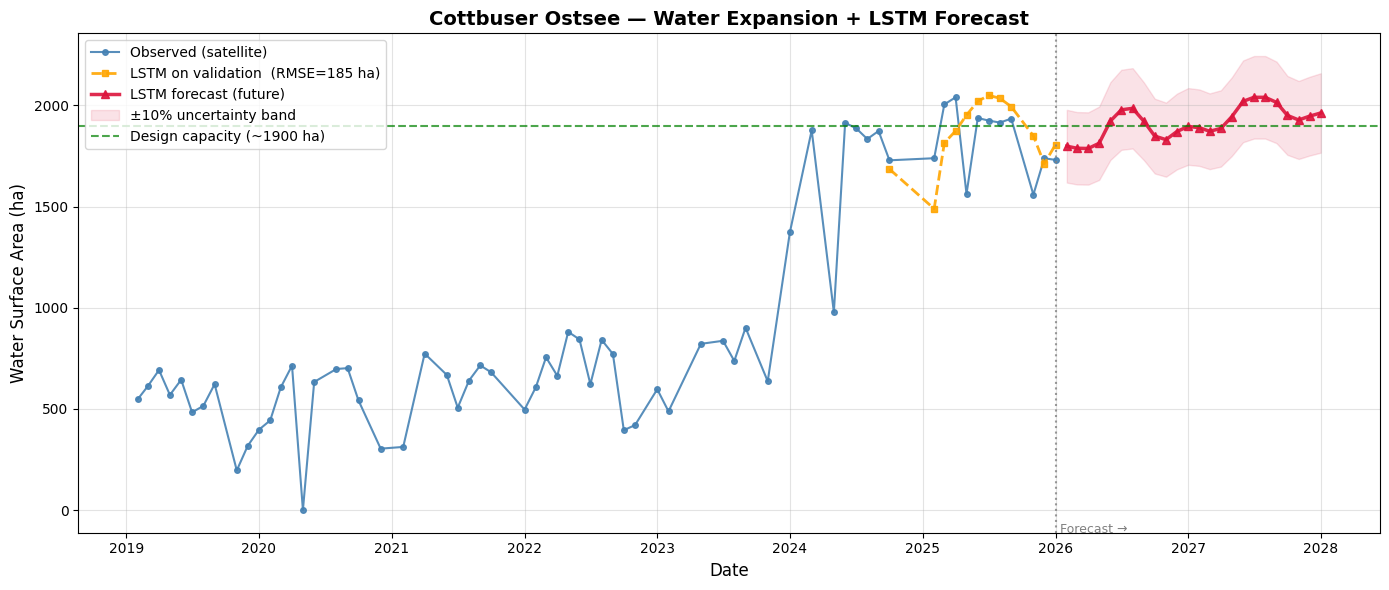

🎯 Model predicts full capacity (1900 ha) reached: 2026-06


In [20]:
# ── Full visualisation ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data
hist_dates = pd.to_datetime(dates)
ax.plot(hist_dates, water_values,
        "o-", color="steelblue", linewidth=1.5, markersize=4,
        label="Observed (satellite)", alpha=0.9)

# Validation predictions
val_start_idx = split + SEQ_LEN
val_dates_plot = pd.to_datetime(dates[val_start_idx : val_start_idx + len(val_preds_ha)])
ax.plot(val_dates_plot, val_preds_ha,
        "s--", color="orange", linewidth=2, markersize=5,
        label=f"LSTM on validation  (RMSE={rmse:.0f} ha)", alpha=0.9)

# Forecast
ax.plot(forecast_df["date"], forecast_df["water_area_ha"],
        "^-", color="crimson", linewidth=2.5, markersize=6,
        label="LSTM forecast (future)", alpha=0.9)

# Confidence shading (±10% as approximate uncertainty)
forecast_upper = forecast_df["water_area_ha"] * 1.10
forecast_lower = forecast_df["water_area_ha"] * 0.90
ax.fill_between(forecast_df["date"], forecast_lower, forecast_upper,
                color="crimson", alpha=0.12, label="±10% uncertainty band")

# Design capacity reference
DESIGN_CAPACITY_HA = 1900
ax.axhline(y=DESIGN_CAPACITY_HA, color="green", linestyle="--",
           linewidth=1.5, alpha=0.7, label=f"Design capacity (~{DESIGN_CAPACITY_HA} ha)")

# Vertical line at forecast start
ax.axvline(x=pd.to_datetime(dates[-1]), color="gray",
           linestyle=":", linewidth=1.5, alpha=0.8)
ax.text(pd.to_datetime(dates[-1]), ax.get_ylim()[0] * 1.02,
        " Forecast →", color="gray", fontsize=9)

ax.set_title("Cottbuser Ostsee — Water Expansion + LSTM Forecast",
             fontsize=14, fontweight="bold")
ax.set_ylabel("Water Surface Area (ha)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.35)

plt.tight_layout()
plt.savefig("lstm_forecast.png", dpi=150, bbox_inches="tight")
plt.show()

# When does model predict full capacity?
above_capacity = forecast_df[forecast_df["water_area_ha"] >= DESIGN_CAPACITY_HA]
if len(above_capacity) > 0:
    print(f"🎯 Model predicts full capacity ({DESIGN_CAPACITY_HA} ha) reached: "
          f"{above_capacity['date'].iloc[0].strftime('%Y-%m')}")
else:
    final = forecast_df['water_area_ha'].iloc[-1]
    print(f"Model predicts {final:.0f} ha after {FORECAST_MONTHS} months "
          f"(full capacity not yet reached in forecast window)")


## 19) Anomaly Detection — Ecologically Significant Events

The LSTM learns the **expected** pattern of water expansion.

When the actual observation deviates significantly from what the model expected,
that month is flagged as an anomaly — something ecologically or meteorologically unusual happened.

**Examples of what anomalies can represent:**
- Drought year → less water than expected
- Unusually wet summer → more water than expected
- Management decision → sudden change in filling rate
- Sensor/cloud issue → data quality problem

We flag months where the prediction error exceeds **1.5 standard deviations** from the mean error.


In [21]:
# ── Compute residuals on training data ────────────────────────
model_lstm.eval()
all_preds, all_targets, all_dates_used = [], [], []

with torch.no_grad():
    X_all = torch.FloatTensor(X_arr).to(DEVICE)
    preds_all = model_lstm(X_all).cpu().numpy().flatten()

preds_ha_all   = denormalise(preds_all)
targets_ha_all = denormalise(y_arr)

# Date for each window = date of the TARGET (what we predicted)
target_dates = pd.to_datetime(dates[SEQ_LEN:])

residuals    = targets_ha_all - preds_ha_all  # positive = more water than expected
residual_std = residuals.std()
residual_mean = residuals.mean()

ANOMALY_THRESHOLD = 1.5  # standard deviations
anomaly_mask = np.abs(residuals - residual_mean) > ANOMALY_THRESHOLD * residual_std

anomaly_df = pd.DataFrame({
    "date":        target_dates,
    "observed_ha": targets_ha_all,
    "predicted_ha": preds_ha_all,
    "residual_ha": residuals,
    "anomaly":     anomaly_mask
})

n_anomalies = anomaly_mask.sum()
print(f"Total months analysed:    {len(anomaly_df)}")
print(f"Anomalies detected:       {n_anomalies}  "
      f"({n_anomalies/len(anomaly_df)*100:.1f}%)")
print(f"Threshold: ±{ANOMALY_THRESHOLD} std = ±{ANOMALY_THRESHOLD * residual_std:.0f} ha")
print(f"\nFlagged months:")
print(anomaly_df[anomaly_df["anomaly"]][
    ["date","observed_ha","predicted_ha","residual_ha"]
].to_string(index=False))


Total months analysed:    58
Anomalies detected:       6  (10.3%)
Threshold: ±1.5 std = ±402 ha

Flagged months:
      date  observed_ha  predicted_ha  residual_ha
2020-05-01     0.000000    668.735352  -668.735352
2024-01-01  1372.929932    688.076050   684.853882
2024-03-01  1876.959961    686.589722  1190.370239
2024-06-01  1913.439941   1121.820068   791.619873
2024-07-01  1887.299927   1386.289185   501.010742
2025-05-01  1561.880005   1952.118408  -390.238403


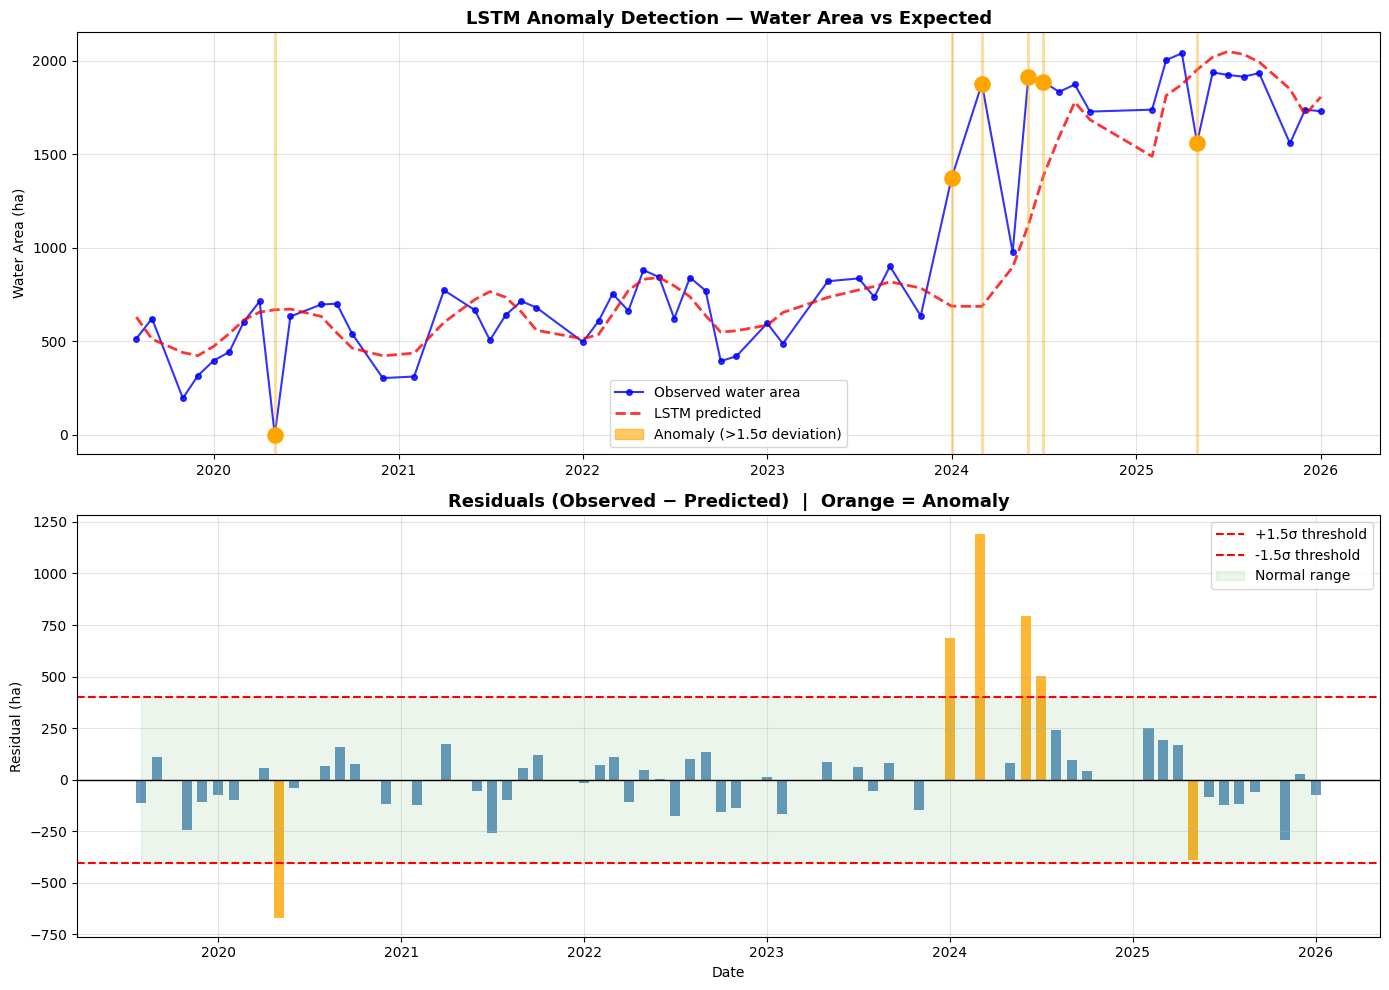


💡 Interpretation guide:
  Positive residual → MORE water than LSTM expected
  Negative residual → LESS water than LSTM expected
  Orange bars       → ecologically significant deviation


In [22]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ── Top: Time series with anomalies flagged ───────────────────
axes[0].plot(anomaly_df["date"], anomaly_df["observed_ha"],
             "b-o", linewidth=1.5, markersize=4,
             label="Observed water area", alpha=0.8)
axes[0].plot(anomaly_df["date"], anomaly_df["predicted_ha"],
             "r--", linewidth=2, label="LSTM predicted", alpha=0.8)

# Highlight anomalies
for _, row in anomaly_df[anomaly_df["anomaly"]].iterrows():
    axes[0].axvline(x=row["date"], color="orange",
                    alpha=0.4, linewidth=2)
    axes[0].scatter(row["date"], row["observed_ha"],
                    color="orange", s=120, zorder=5)

# Add legend patch
orange_patch = mpatches.Patch(color="orange", alpha=0.6,
                               label=f"Anomaly (>{ANOMALY_THRESHOLD}σ deviation)")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles + [orange_patch], fontsize=10)
axes[0].set_title("LSTM Anomaly Detection — Water Area vs Expected",
                  fontsize=13, fontweight="bold")
axes[0].set_ylabel("Water Area (ha)")
axes[0].grid(True, alpha=0.35)

# ── Bottom: Residuals ─────────────────────────────────────────
axes[1].bar(anomaly_df["date"], anomaly_df["residual_ha"],
            color=["orange" if a else "steelblue"
                   for a in anomaly_df["anomaly"]],
            width=20, alpha=0.8)
axes[1].axhline(y=0, color="black", linewidth=1)
axes[1].axhline(y= ANOMALY_THRESHOLD * residual_std,
                color="red", linestyle="--", linewidth=1.5,
                label=f"+{ANOMALY_THRESHOLD}σ threshold")
axes[1].axhline(y=-ANOMALY_THRESHOLD * residual_std,
                color="red", linestyle="--", linewidth=1.5,
                label=f"-{ANOMALY_THRESHOLD}σ threshold")
axes[1].fill_between(anomaly_df["date"],
                     -ANOMALY_THRESHOLD * residual_std,
                      ANOMALY_THRESHOLD * residual_std,
                     alpha=0.08, color="green",
                     label="Normal range")

axes[1].legend(fontsize=10)
axes[1].set_title("Residuals (Observed − Predicted)  |  Orange = Anomaly",
                  fontsize=13, fontweight="bold")
axes[1].set_ylabel("Residual (ha)")
axes[1].set_xlabel("Date")
axes[1].grid(True, alpha=0.35)

plt.tight_layout()
plt.savefig("anomaly_detection.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n💡 Interpretation guide:")
print("  Positive residual → MORE water than LSTM expected")
print("  Negative residual → LESS water than LSTM expected")
print("  Orange bars       → ecologically significant deviation")


## 20) AI Results Summary

### What the LSTM Learned

The model was trained on monthly water area observations from 2019 onwards.  
It learned to model both:
- The **seasonal cycle** — water area fluctuates within years (evaporation, rainfall)
- The **long-term trend** — consistent lake filling driven by mine water management

### Forecast Interpretation

The 24-month autoregressive forecast shows the expected trajectory of lake filling  
assuming current conditions continue. The ±10% uncertainty band reflects model uncertainty.

### Anomaly Interpretation

Flagged months represent deviations from the LSTM's learned model of lake dynamics.  
These warrant investigation — they may reflect:
- Unusual meteorological events (drought, flood)
- Changes in water management decisions
- Ecosystem regime shifts as the lake matures

### Limitations

- Training data is limited (~7 years, ~84 monthly observations)
- Forecast uncertainty increases with time horizon
- Model does not incorporate external drivers (rainfall, temperature, management decisions)
- Adding climate variables as additional features would improve forecast skill

---

## 📋 Validation Placeholder (Thesis Recommendation)

| Year | Satellite Area (ha) | Official LMBV Area (ha) | Error (%) |
|------|---------------------|------------------------|-----------|
| 2020 | — | — | — |
| 2022 | — | — | — |
| 2024 | — | — | — |

Fill this table using Brandenburg Geoportal or LMBV project reports  
to provide thesis-level validation of the satellite measurements.

---

## 📁 Output Files

| File | Description |
|------|-------------|
| `water_area_timeseries.csv` | Complete per-scene, monthly, yearly water areas |
| `water_timeseries.png` | Time series + trend plot |
| `habitat_diversity.png` | Shannon diversity map |
| `water_expansion_animation.gif` | Water expansion time-lapse |
| `biodiversity_proxy_animation.gif` | NDVI vegetation time-lapse |
| `lstm_training_history.png` | LSTM loss curves |
| `lstm_forecast.png` | Water expansion forecast plot |
| `anomaly_detection.png` | Anomaly detection plot |
